# Examen práctico 
## Parcial 1 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [2]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure(figsize=(10, 5))
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.grid()
    plt.legend()
    plt.show()

def vibariado(df, y):

     target = y.name

     for i in df.keys():
          #df = df.copy().drop(y.name, axis=1)
          X = df[[i]]
          model = linear_model.LinearRegression().fit(X, y)

          if len(X.iloc[:, 0].unique()) < 5:
               q = len(X.iloc[:, 0].unique())
          else:
               q = 10

          df[X.keys()[0] + str("bin")] = pd.qcut(df[X.keys()[0]], q=q, labels=False, duplicates="drop") + 1
          grouped = df.groupby((X.keys()[0] + str("bin"))).mean()

          plt.figure(figsize=(10,5))
          plt.plot(grouped[X.keys()[0]].values, grouped[target].values, color=colors[0], marker='o')
          plt.xlabel(f"{X.keys()[0]} bins")
          plt.ylabel(target)
          plt.title(f"Análisis bivariado entre {X.keys()[0]} y {target}")
          plt.grid()
          plt.show()

          df = df.drop(columns=[X.keys()[0] + str("bin")])

          print()

def comparacion(modelos, y):
     plt.figure(figsize=(10, 5))

     for i, modelo in enumerate(modelos):
          col_pred = f'predicciones_{modelo}'

          df_calibracion = pd.DataFrame({
               'predicciones': globals()[col_pred],
               'y': y
          })

          df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=10, labels=False)+1
          grouped = df_calibracion.groupby('bins').mean()
          plt.plot(grouped['predicciones'].values, grouped['y'].values, marker='o', color=colors[i], label=modelos[i])

     plt.plot(grouped['predicciones'].values, grouped['predicciones'].values, color=colors[4], linestyle="--", label="Real")
     plt.xlabel("Valores predichos")
     plt.ylabel("Valores reales")
     plt.title("Comparación de modelos")
     plt.grid()
     plt.legend()
     plt.show()

def graficas_KNN(resultados, nn_opt):
     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  

     axes[0].plot(resultados.nn, resultados.r2, label='real', color=colors[0], marker='o')
     axes[0].grid()
     axes[0].set_title("$R^2$ Real")
     axes[0].set_xlabel("Nearest Neighbors")
     axes[0].set_ylabel("$R^2$")

     axes[1].plot(resultados.nn, resultados.r2_train, label='train', color=colors[1], marker='o')
     axes[1].grid()
     axes[1].set_title("$R^2$ Train")
     axes[1].set_xlabel("Nearest Neighbors")
     axes[1].set_ylabel("$R^2$")

     plt.show()

     plt.figure(figsize=(15, 5))
     plt.plot(resultados.nn, resultados.r2, label='Real', color=colors[0], marker='o')
     plt.plot(resultados.nn, resultados.r2_train, label='Train', color=colors[1], marker='o')
     plt.scatter(nn_opt, max(resultados.r2), label=f'Óptimo nn = {nn_opt}', color=colors[2], s=50, zorder=3)
     plt.text(nn_opt, max(resultados.r2)-0.05, f"Máximo $R^2$", va='bottom')
     plt.grid()
     plt.legend()
     plt.title("$R^2$ Real vs Train")
     plt.xlabel("Nearest Neighbors")
     plt.ylabel("$R^2$")
     plt.show()

def AB_test(test, control):
    # Mu
    mu_test = test.mean()
    mu_control = control.mean()

    # SE
    se_test = test.sem()
    se_control = control.sem()

    # Differences
    mu_diff = mu_control - mu_test
    se_diff = np.sqrt((test.var() / len(test) + (control.var() / len(control))))

    # Z score and p value 
    z = mu_diff / se_diff

    p_value = stats.norm.cdf(z)

    print(f"Intervalo variable test: ({mu_test - 2*se_test:,.4f}, {mu_test + 2*se_test:,.4f})")
    print(f"Intervalo variable control: ({mu_control - 2*se_control:,.4f}, {mu_control + 2*se_control:,.4f})")
    print(f'Intervalo de confianza del efecto causal: ({mu_diff - 2*se_diff:,.4f}, {mu_diff + 2*se_diff:,.4f})')
    print(f"Z score {z:,.4f}")
    print(f"P-value {p_value:,.4f}")

# Data

In [3]:
data = pd.read_csv("Data/Boston.csv")
data.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Limpieza de datos

In [4]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Variable dependiente

In [5]:
target = 'medv'
y = data[target]

# AB testing

In [6]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [7]:
controls = data.keys().drop(target)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,41.6173,4.936,8.431,0.000,31.919,51.316
crim,-0.1214,0.033,-3.678,0.000,-0.186,-0.057
zn,0.0470,0.014,3.384,0.001,0.020,0.074
indus,0.0135,0.062,0.217,0.829,-0.109,0.136
chas,2.8400,0.870,3.264,0.001,1.131,4.549
nox,-18.7580,3.851,-4.870,0.000,-26.325,-11.191
rm,3.6581,0.420,8.705,0.000,2.832,4.484
age,0.0036,0.013,0.271,0.787,-0.023,0.030
dis,-1.4908,0.202,-7.394,0.000,-1.887,-1.095
rad,0.2894,0.067,4.325,0.000,0.158,0.421


In [8]:
controls = controls.drop('indus')
data.drop('indus', axis=1, inplace=True)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,41.5437,4.920,8.445,0.000,31.878,51.210
crim,-0.1216,0.033,-3.691,0.000,-0.186,-0.057
zn,0.0466,0.014,3.383,0.001,0.020,0.074
chas,2.8591,0.865,3.307,0.001,1.160,4.558
nox,-18.5349,3.708,-4.999,0.000,-25.819,-11.250
rm,3.6500,0.418,8.728,0.000,2.828,4.472
age,0.0036,0.013,0.271,0.787,-0.023,0.030
dis,-1.5000,0.197,-7.617,0.000,-1.887,-1.113
rad,0.2854,0.064,4.443,0.000,0.159,0.412
tax,-0.0123,0.003,-3.611,0.000,-0.019,-0.006


In [9]:
controls = controls.drop('age')
data.drop('age', axis=1, inplace=True)


result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,41.4517,4.903,8.454,0.000,31.818,51.086
crim,-0.1217,0.033,-3.696,0.000,-0.186,-0.057
zn,0.0462,0.014,3.378,0.001,0.019,0.073
chas,2.8719,0.863,3.329,0.001,1.177,4.567
nox,-18.2624,3.565,-5.122,0.000,-25.267,-11.258
rm,3.6730,0.409,8.978,0.000,2.869,4.477
dis,-1.5160,0.188,-8.078,0.000,-1.885,-1.147
rad,0.2839,0.064,4.440,0.000,0.158,0.410
tax,-0.0123,0.003,-3.608,0.000,-0.019,-0.006
ptratio,-0.9310,0.130,-7.138,0.000,-1.187,-0.675


# Análisis vibariado

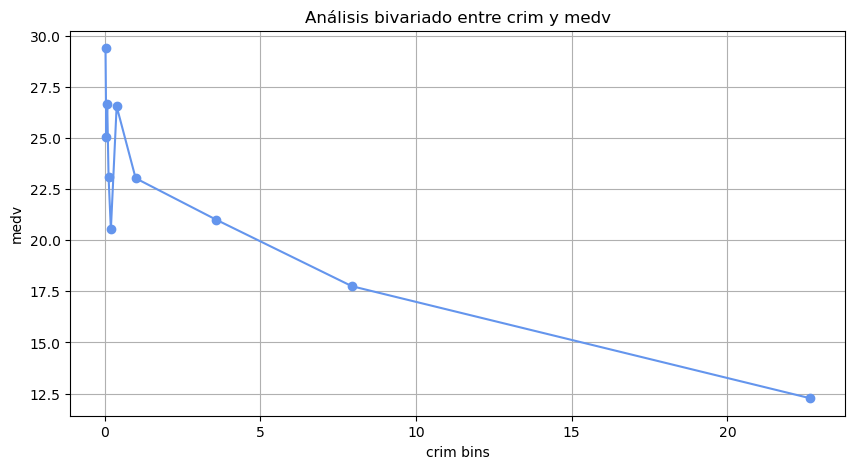

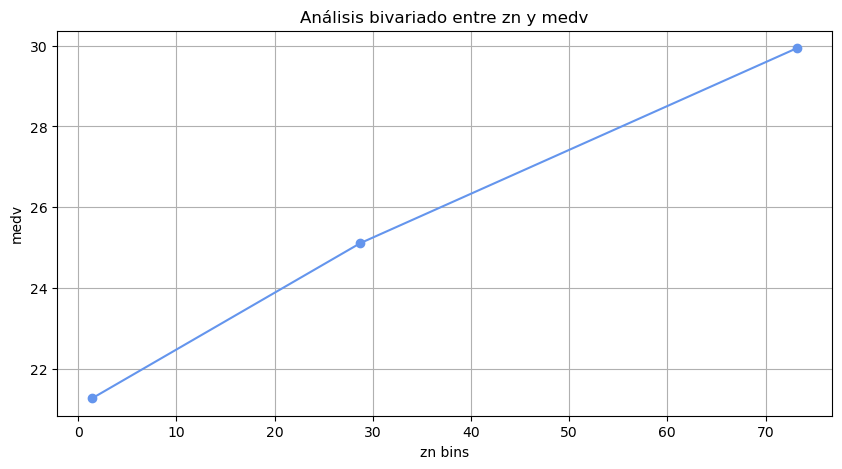

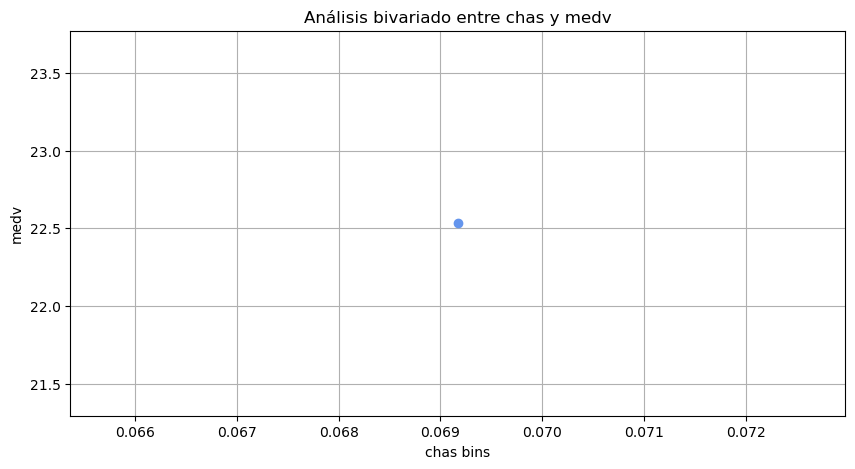

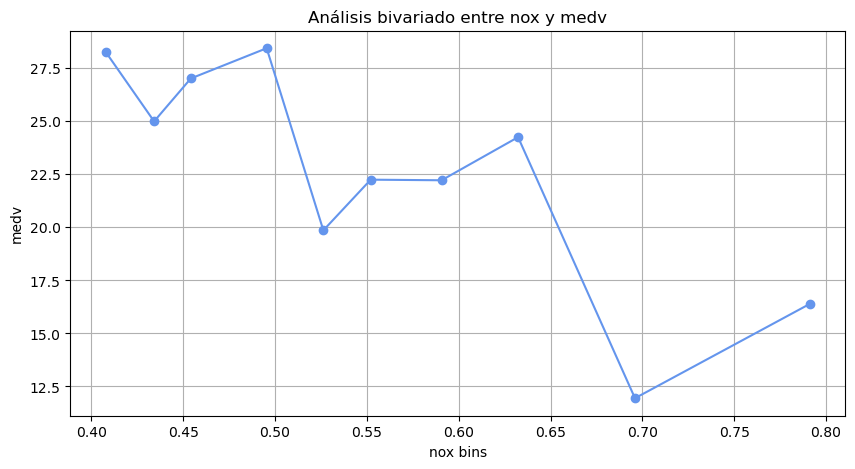

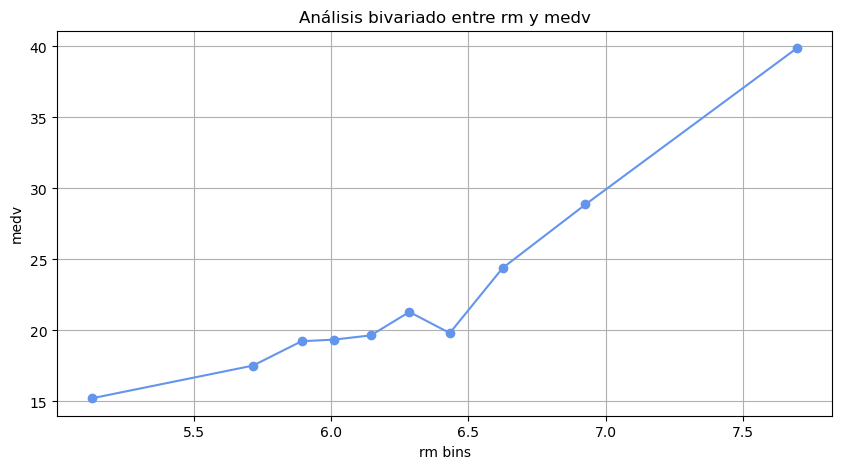

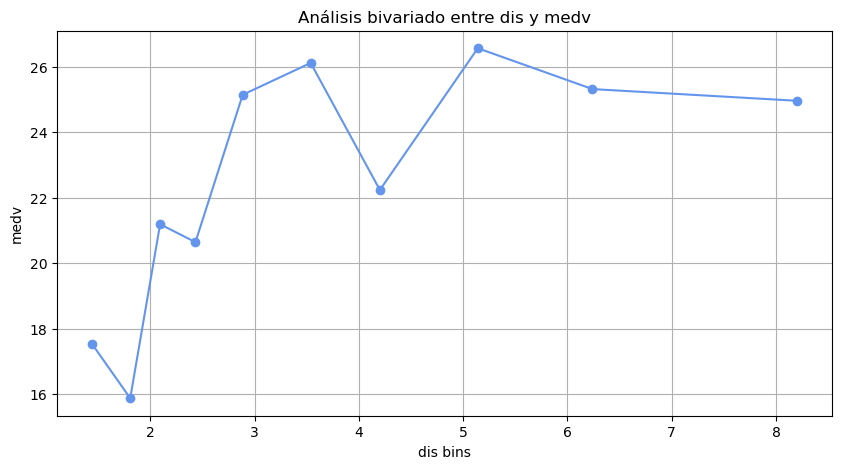

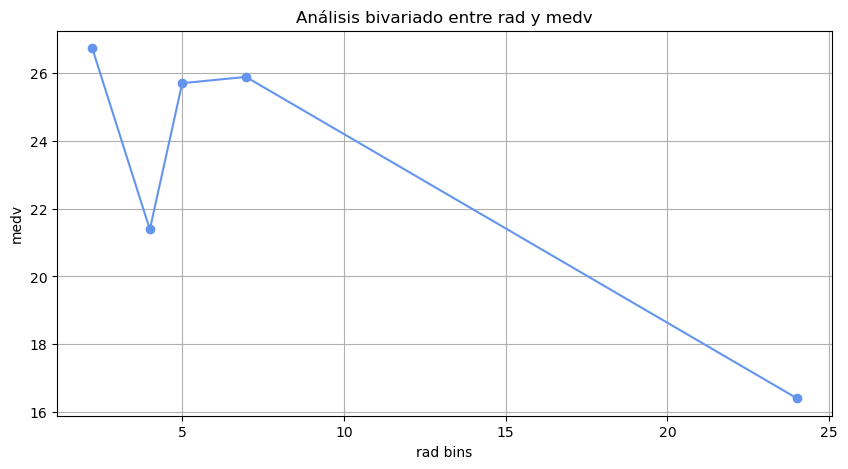

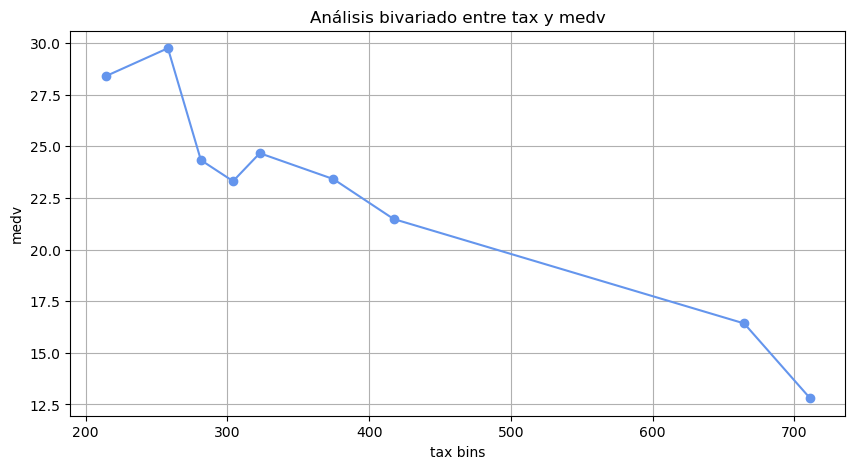

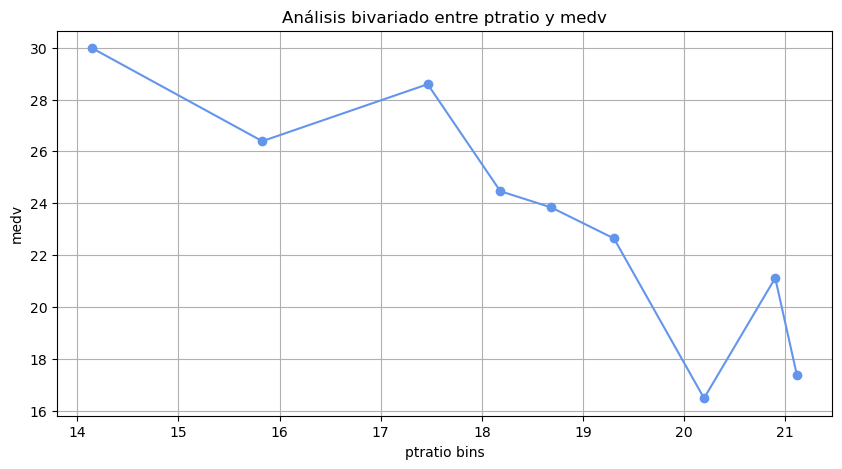

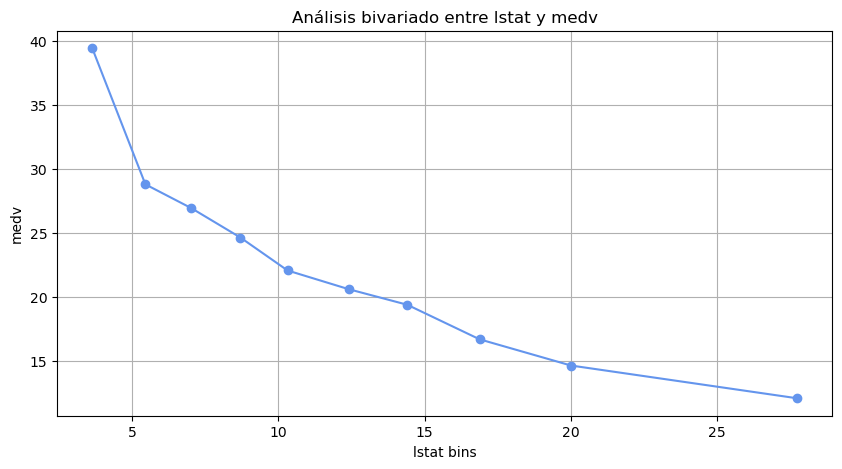

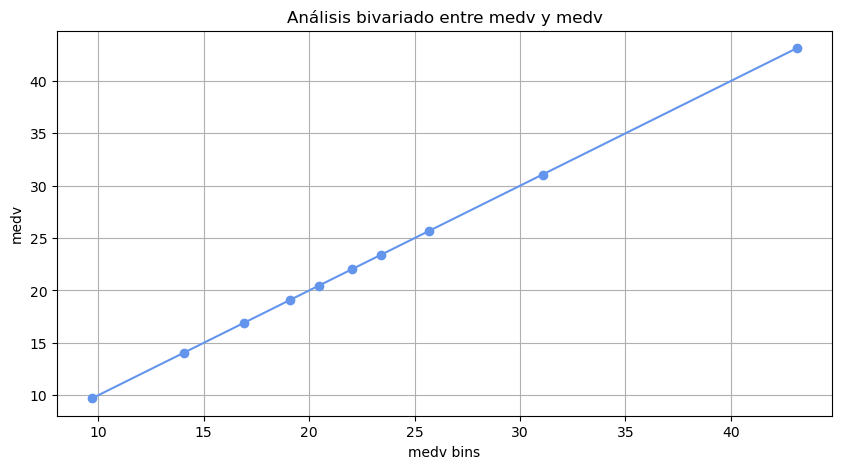

In [10]:
vibariado(data, y)

# Preparación de datos

## Cross validation

In [11]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaler

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regresión lineal múltiple

In [13]:
model = linear_model.LinearRegression().fit(X_train_scaled, y_train)
predicciones_RLM = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.6968
MSE: 22.2315

Intercepto del modelo: 22.80
Coeficientes del modelo:


,names,coeficientes
0,crim,-1.221368
1,zn,0.952356
2,chas,0.790116
3,nox,-2.392528
4,rm,2.932298
5,dis,-3.019446
6,rad,1.567782
7,tax,-1.875481
8,ptratio,-1.919375
9,lstat,-3.979784


## Calibración

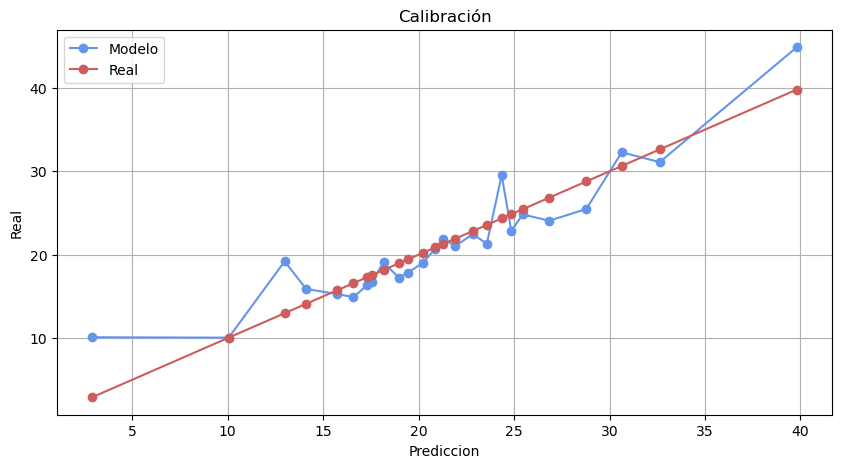

In [14]:
calibracion(predicciones_RLM, y_test, 25)

# Regresión polinomial

## Grado 2

In [15]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly2 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7428
MSE: 18.8595


### Calibración

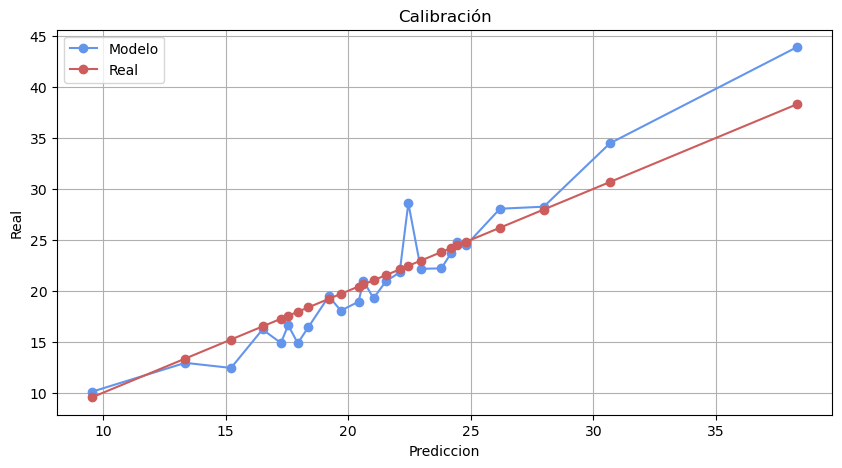

In [16]:
calibracion(predicciones_poly2, y_test, 25)

## Grado 3

In [17]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly3 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7770
MSE: 16.3500


### Calibración

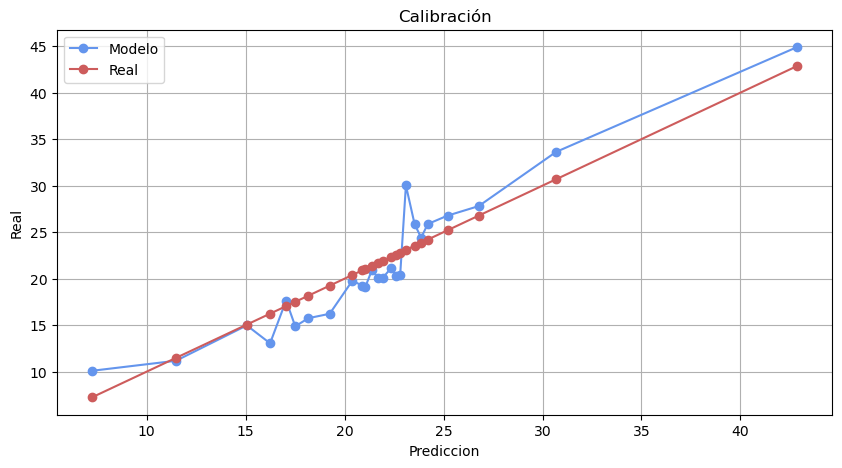

In [18]:
calibracion(predicciones_poly3, y_test, 25)

## Grado 4

In [19]:
degree = 4

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly4 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly4)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly4)
print(f"MSE: {mse:,.4f}")

R² Score: 0.6633
MSE: 24.6911


### Calibración

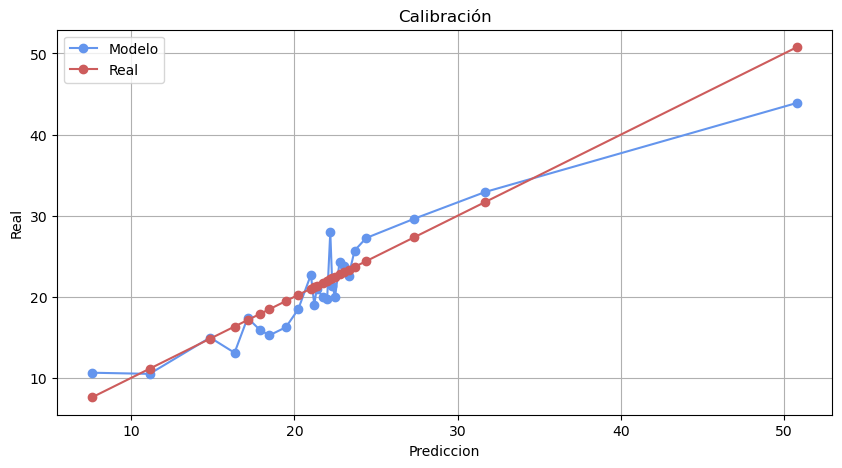

In [20]:
calibracion(predicciones_poly4, y_test, 25)

# KNN

# Conclusiones generales